# Can we beat the S&P 500

There's an entire industry devoted to this question. Can you beat the market? Usually the market is the S&P 500 which is a basket of the top 500 securities on the stock exchange weighted by market capitilization.

So for instance the S&P 500 contains stocks like AAPL, or GOOG weighted by how valuable each of those companies would theoretically sell for.

According to William Sharpe, Nobel Laureate and Fama and French really this whole exercise is dismal but perhaps we can come up with something better? In machine learning it's always important to try and see what comes out. Even if we can squeeze out an extra basis point (1/10th of a percent) our high net worth clients might pay us graciously for that!

# Forget about CRISP-DM focus on TACT

For my own work I have built my own method which is easier to remember called TACT. It's _very_ similar to CRISP-DM (which you should also look up). It stands for Target, Arrange, Compose, and Transmit.


We will be going through this process in the next two labs

# Target

What is our target? Make as much return as possible? Limit the volatility? Make the best risk adjusted return?

Sharpe Ratio?

Sortino Ratio?

Part of the difficulty with finance is that the optimization is very convex, very stochastic, and many times picking the right objective (or similar loss) is very very important!


If we were going to maximize return most likely we would pick one stock and stick with it, which isn't a great idea. If we were to lower volatility we'd probably just hold cash. Risk adjusted return is about balancing these two concerns and many times shows up in modern portfolio theory called mean variance optimization or MVO for short. 

This effectively tries to limit volatility subject to the return being high enough. That is a great method although really what we're interested in in more specific. We want to beat the S&P 500.

For that there are two major methods:

1. Sharpe ratio which is a measure of return above a risk free return (treasury bonds usually)
2. Sortino ratio. This is a modification of the sharpe ratio that minimizes downside risk of a portfolio
3. Tracking error. This one is subtle. We might want to match the S&P 500 as much as possible while minimizing trading. This shows how well we replicate the S&P 500.

# Arrange the data

In [ ]:
# First step is collecting the data

# https://www.kaggle.com/camnugent/sandp500/downloads/sandp500.zip/4

# https://www.kaggle.com/dgawlik/nyse

# 

/home/hexgnu/git/oreilly/rl-oreilly-course/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  del sys.path[0]


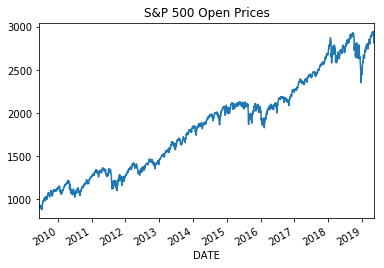

In [2]:
# First what does the S&P look like?
# Collected from https://fred.stlouisfed.org/series/SP500/
import pandas as pd
import matplotlib.pyplot as plt

sp500 = pd.read_csv('./SP500.csv', parse_dates=[0], index_col='DATE').sort_index()
sp500 = sp500.rename(columns={'SP500': 'OPEN'})

sp500 = sp500[sp500['OPEN'] != '.']

sp500['OPEN'] = sp500['OPEN'].astype('float')

sp500['sp500_return'] = sp500['OPEN'].rolling(window=2, center=False).apply(lambda x: x[1] / x[0] - 1)

sp500['OPEN'].plot(title='S&P 500 Open Prices')

plt.show()

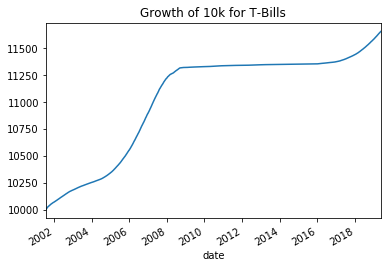

In [3]:
# What does the treasury bonds look like?

import pandas as pd

tbills = pd.read_csv('1month_treasury_rate.csv', parse_dates=[0], index_col='date').sort_index()
tbills['rf_return'] = (tbills['1month'] / 100 + 1) ** (1/365) - 1
tbills['tbill_portfolio'] = 10_000 * (tbills['rf_return'] + 1).cumprod()
tbills['tbill_portfolio'].plot(title='Growth of 10k for T-Bills')

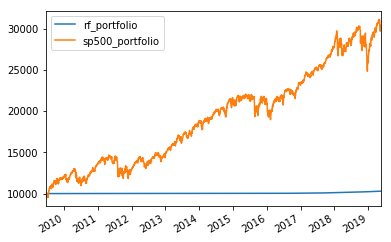

In [4]:
portfolios = tbills.join(sp500, how='inner').dropna()[['rf_return', 'sp500_return']]

portfolios['rf_portfolio'] = 10_000 * (portfolios['rf_return'] + 1).cumprod()
portfolios['sp500_portfolio'] = 10_000 * (portfolios['sp500_return'] + 1).cumprod()

portfolios[['rf_portfolio', 'sp500_portfolio']].plot()

In [5]:
def sharpe_ratio(returns, rf):
    diff = (returns - rf)
    return diff.mean() / diff.std()
    
def tracking_error(returns, benchmark):
    return (returns - benchmark).std()

print("Sharpe Ratio: {}, Tracking Error: {}".format(
        sharpe_ratio(portfolios['sp500_return'], portfolios['rf_return']),
        tracking_error(portfolios['sp500_return'], portfolios['sp500_return'])))

Sharpe Ratio: 0.050578307949029636, Tracking Error: 0.0


In [6]:
import pandas as pd

sp_stocks = pd.read_csv('./prices-split-adjusted.csv', parse_dates=[0])

sp_stocks = sp_stocks.pivot_table(index='date', columns='symbol')['open']

sp_stocks = sp_stocks.rolling(window=2, center=False).apply(lambda x: x[1] / x[0] - 1)

/home/hexgnu/git/oreilly/rl-oreilly-course/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  import sys


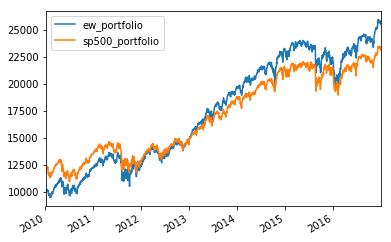

In [7]:
portfolios = portfolios.join(pd.DataFrame({'ew_return': sp_stocks.mean(axis=1)}), how='inner')

portfolios['ew_portfolio'] = 10_000 * (portfolios['ew_return'] + 1).cumprod()

portfolios[['ew_portfolio', 'sp500_portfolio']].plot()

In [8]:
print("Sharpe Ratio: {}, Tracking Error: {}".format(
        sharpe_ratio(portfolios['ew_return'], portfolios['rf_return']),
        tracking_error(portfolios['ew_return'], portfolios['sp500_return'])))

Sharpe Ratio: 0.05719466152885326, Tracking Error: 0.011427847924650621


In [9]:
portfolios.iloc[0]

rf_return              0.000001
sp500_return           0.016043
rf_portfolio       10002.998834
sp500_portfolio    12150.804137
ew_return                   NaN
ew_portfolio                NaN
Name: 2010-01-04 00:00:00, dtype: float64

# Compose an automated trader V1 Using Q-Learning

We have a few objectives we can play with which are optimizing for sharpe ratio or tracking error. Let's tackle the sharpe ratio first. 

The reason why is that we will only be buying, holding, or selling SPY and to optimize tracking error all you'd have to do is buy and hold forever. :)

# Actions

We can either buy, hold, or sell the S&P 500 index. Can we find a way to beat just buying and holding the market?

# States

For this first state we will be hand coding what state the stock is in using Bollinger bands.

Bollinger Bands are a technical trading trick to put a upper and lower bound around stocks based on volatility.

Usually the upper band is the moving average + alpha * moving_stdev and the lower band is moving average + beta * moving_stdev.

As you can imagine this is very hand coded. 

We will start with the basics of +/- 1.5 * stdev and the last 12 trading days. 

What happens when we change it? 

How will you optimize it?

# Parameters

Moving average window. For a regular window
Moving average method. Could be exponentially weighted moving average (which also has a parameter btw).
Upper bound constant
Lower bound constant
Moving stdev method. Could be regular stdev or a downside risk https://en.wikipedia.org/wiki/Sortino_ratio

You can probably see why finance is a tough job...

# Reward

Reward will be the risk adjusted return for the next period

# SARSA

State_1, Action_1, Return_1, State_2, Action_2


# My result (2019-05-17)

# Q-Learning applied to trading the S&P 500

In [22]:
# TODO
# Need to validate a holding

q_returns = create_states(portfolios)

In [153]:
class StockEnv(object):
    def __init__(self, returns):
        self.current_idx = 0
        self.df = self.create_states(returns)
    
    def create_states(self, df_in, window=12, mean=lambda x: x.mean(), volatility=lambda x: x.std(), alpha=1.5, beta=1.5):
        df = df_in[['rf_return', 'sp500_return']].copy()
        df.loc[:, 'risk_adjusted_return'] = df_in['sp500_return'] - df_in['rf_return']
        df.loc[:, 'ra_moving_avg'] = df['risk_adjusted_return'].rolling(window=window).apply(mean, raw=False)
        df.loc[:, 'ra_moving_volatility'] = df['risk_adjusted_return'].rolling(window=window).apply(volatility, raw=False)
        df.loc[:, 'ra_high'] = df['ra_moving_avg'] + alpha * df['ra_moving_volatility']
        df.loc[:, 'ra_low'] = df['ra_moving_avg'] - beta * df['ra_moving_volatility']
        df.loc[:, 'state'] = (df['risk_adjusted_return'] > df['ra_high']).astype('int') - \
                             (df['risk_adjusted_return'] < df['ra_low']).astype('int')
        return df
    
    def reset(self):
        '''
        Returns to beginning state
        '''
        self.current_idx = 1
    
    def step(self, action):
        # Are we in the terminal state?
        done = self.current_idx == self.df.shape[0] - 1
        s_0 = self.df.iloc[self.current_idx - 1]['state']
        
        if done:
            this_state = self.df.iloc[self.current_idx]['state']
            reward = None
            self.reset()
        else:
            this_state = self.df.iloc[self.current_idx]['state']
            reward = action * self.df.iloc[self.current_idx + 1]['risk_adjusted_return']
            self.current_idx += 1

        return (s_0, action, reward, this_state, done)
        
# env = StockEnv(portfolios[:300])

# action = 1
# env.reset()

# s_0, action, reward, s_1, done = env.step(action)
# print("{}: S_0={} A={} R={} S_1={} DONE={}".format(portfolios.iloc[env.current_idx-1].name, s_0, action, reward, s_1, done))

# while not done:
#     s_0, action, reward, s_1, done = env.step(action)
#     print("{}: S_0={} A={} R={} S_1={} DONE={}".format(portfolios.iloc[env.current_idx-1].name, s_0, action, reward, s_1, done))

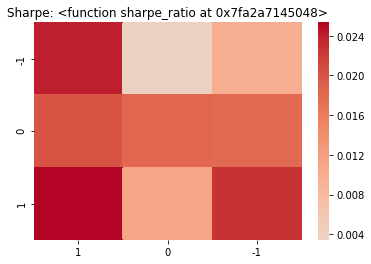

In [159]:
q = {1: {-1:0, 0:0, 1:0}, 0: {-1:0, 0:0, 1:0}, -1: {-1:0, 0:0, 1:0}}

train_env = StockEnv(portfolios[:1398])

class QAgent(object):
    def __init__(self, environment):
        self.q = {}
        for s in environment.states:
            objectives = {}
            for a in environment.actions:
                objectives[a] = 0
            self.q[s] = objectives
        
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
    
        

def pick_action(state, q):
    if random.random() > 0.001:
        return max(q[state], key=q[state].get)
    else:
        # Once in a while just pick something at random
        return random.randint(-1,1)

action = pick_action(0, q)

env.reset()
done = False

alpha = 0.9
discount = 0.9

episodes = 100

while episodes:
    s_0, _, reward, s_1, done = env.step(action)
    
    if done:
        env.reset()
        done = False
        action = pick_action(0, q)
        episodes -= 1
        
        clear_output(True)
        ax = plt.axes()
        sns.heatmap(pd.DataFrame(q), center=0, cmap='coolwarm', ax=ax)
        ax.set_title('Sharpe: {}'.format(sharpe_ratio))
        plt.show()
        continue
    
    q[s_0][action] = (1-alpha) * q[s_0][action] + alpha *(reward + discount * (max(q[s_1].values())))
    
    action = pick_action(s_0, q)

In [160]:
q

{1: {-1: 0.02394341179576072, 0: 0.02011989376934667, 1: 0.025354040204936867},
 0: {-1: 0.003442039168785011,
  0: 0.01837435690753979,
  1: 0.011299139773326538},
 -1: {-1: 0.009995582146413242,
  0: 0.018177818851661958,
  1: 0.022863613407367638}}

In [163]:
test_env = StockEnv(portfolios[1398:])

def replay(df, qin):
    q = qin.copy()
    
    def greedy_action(s):
        if np.isnan(s):
            return 0
        else:
            return max(q[s], key=q[s].get)

    actions = q_returns['state'].shift().apply(greedy_action)
    
    return (actions * q_returns['risk_adjusted_return']).mean() / (actions * q_returns['risk_adjusted_return']).std()

buy_and_hold = {1: {1:1, 0:0, -1:0}, 0: {1: 1, 0:0, -1:0}, -1:{1: 1, 0:0, -1:0}}

replay(q_returns, buy_and_hold)

0.04247604611691006

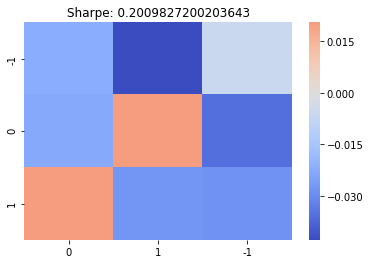

0.19277619449744682


In [80]:
import numpy as np
import random
import seaborn as sns
from IPython.display import clear_output

def sharpe(holdings, df):
    '''
    Holdings in {-1, 0, 1}
    '''
    returns = holdings * df.loc[holdings.index, 'risk_adjusted_return']

    return returns.mean() / returns.std()

def q_holdings(X_train, X_test, episodes=100, alpha=0.9, discount=0.9):
    factors = pd.DataFrame({'action': 0, 'reward': 0, 'state': 0}, index=X_train.index)

    # Initialize Q matrix
    # 
    q = {0: {1:0, 0:0, -1:0}, 1: {1:0, 0:0, -1:0}, -1: {1:0, 0:0, -1:0}}

    # For Dyna-Q (???)
    T = np.zeros((3, 3, 3)) + 0.00001
    R = np.zeros((3,3))
    
    for i in range(episodes):
        last_row, last_date = None, None

        for date, row in factors.iterrows():
            if last_row is None or np.isnan(X_train.loc[date, 'state']):
                # There are going to be a few dates that just have NaNs
                state = 0
                reward = 0
                action = 0
            else:
                state = int(X_train.loc[date, 'state'])
                
                if random.random() > 0.001:
                    # I think this is argmax?
                    action = max(q[state], key=q[state].get)
                else:
                    # Once in a while just pick something at random
                    action = random.randint(-1,1)

                # Important to use the last action since otherwise we'd be cheating :-D
                reward = last_row['action'] * X_train.loc[date, 'risk_adjusted_return']
                
                factors.loc[date, 'reward'] = reward
                factors.loc[date, 'action'] = action
                factors.loc[date, 'state'] = state

                update = alpha * (factors.loc[date, 'reward'] + \
                                  discount * max(q[row.state].values()) - \
                                  q[state][action])
                
                if not np.isnan(update):
                    q[state][action] += update

                # Dyna
                action_idx = int(last_row.action + 1)
                state_idx = int(last_row.state + 1)
                new_state_idx = int(state + 1)

                T[state_idx][action_idx][new_state_idx] += 1
                R[state_idx][action_idx] = (1 - alpha) * R[state_idx][action_idx] + alpha * reward

            last_date, last_row = date, factors.loc[date]

        # DYNA?
        for j in range(episodes):
            state_idx = random.randint(0,2)
            action_idx = random.randint(0,2)
            new_state = np.random.choice([-1, 0, 1], 1, p=T[state_idx][action_idx]/T[state_idx][action_idx].sum())[0]
            r = R[state_idx][action_idx]
            q[state][action] += alpha * (r + discount * max(q[new_state].values()) - q[state][action])

        sharpe_ratio = sharpe(factors.action, X_train)
        
        clear_output(True)
        ax = plt.axes()
        sns.heatmap(pd.DataFrame(q), center=0, cmap='coolwarm', ax=ax)
        ax.set_title('Sharpe: {}'.format(sharpe_ratio))
        plt.show()
        
        if sharpe_ratio > 0.15:
            break

    testing = pd.DataFrame({'action': 0, 'state': 0}, index=X_test.index)
    testing['state'] = X_test['state']
    testing['action'] = testing['state'].apply(lambda state: max(q[state], key=q[state].get))

    print(sharpe(testing.action, X_test))

    return (q, testing.action)

# 80/20 split
q, test_holdings = q_holdings(q_returns.iloc[:1398], q_returns.iloc[1398:])

In [93]:
testing = q_returns.iloc[300:]

testing['last_state'] = testing['state'].shift()
testing = testing.dropna()

testing['action'] = testing['last_state'].apply(lambda state: max(q[state], key=q[state].get))

sharpe(testing['action'], testing)

/home/hexgnu/git/oreilly/rl-oreilly-course/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.044340150901972936

In [94]:
testing['action']

2011-03-17    1
2011-03-18    1
2011-03-21    1
2011-03-22    1
2011-03-23    1
2011-03-24    1
2011-03-25    1
2011-03-28    1
2011-03-29    1
2011-03-30    1
2011-03-31    1
2011-04-01    1
2011-04-04    1
2011-04-05    1
2011-04-06    1
2011-04-07    1
2011-04-08    1
2011-04-11    1
2011-04-12    1
2011-04-13   -1
2011-04-14    1
2011-04-15    1
2011-04-18    1
2011-04-19   -1
2011-04-20    1
2011-04-21    0
2011-04-25    1
2011-04-26    1
2011-04-27    1
2011-04-28    1
             ..
2016-11-17    1
2016-11-18    1
2016-11-21    1
2016-11-22    1
2016-11-23    1
2016-11-25    1
2016-11-28    1
2016-11-29   -1
2016-11-30    1
2016-12-01    1
2016-12-02    1
2016-12-05    1
2016-12-06    1
2016-12-07    1
2016-12-08    0
2016-12-09    1
2016-12-12    1
2016-12-13    1
2016-12-14    1
2016-12-15   -1
2016-12-16    1
2016-12-19    1
2016-12-20    1
2016-12-21    1
2016-12-22    1
2016-12-23    1
2016-12-27    1
2016-12-28    1
2016-12-29   -1
2016-12-30    1
Name: action, Length: 14

In [90]:
testing['risk_adjusted_return'].mean() / testing['risk_adjusted_return'].std()

0.04361543810195592

In [66]:
test_portfolio = q_returns.iloc[300:]
test_portfolio['holding'] = test_holdings

test_portfolio

# test_holdings

# test_portfolio['hold'] = test_holdings

# test_portfolio

/home/hexgnu/git/oreilly/rl-oreilly-course/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,rf_return,sp500_return,risk_adjusted_return,ra_moving_avg,ra_moving_volatility,ra_high,ra_low,state,holding
2011-03-16,1.643344e-06,-0.019495,-0.019497,-4.468666e-03,0.011525,0.012819,-0.021757,0,0
2011-03-17,1.643344e-06,0.013398,0.013397,-2.040483e-03,0.011994,0.015951,-0.020032,0,0
2011-03-18,1.643344e-06,0.004302,0.004301,-1.816418e-03,0.012094,0.016324,-0.019957,0,0
2011-03-21,1.643344e-06,0.014994,0.014992,-2.001717e-03,0.011789,0.015681,-0.019685,0,0
2011-03-22,1.917139e-06,-0.003551,-0.003552,-1.682667e-03,0.011681,0.015839,-0.019204,0,0
2011-03-23,1.643344e-06,0.002914,0.002912,-7.446442e-04,0.011549,0.016578,-0.018068,0,0
2011-03-24,1.095672e-06,0.009341,0.009340,-7.097446e-04,0.011581,0.016662,-0.018082,0,0
2011-03-25,1.095672e-06,0.003161,0.003160,-3.327691e-04,0.011631,0.017114,-0.017780,0,0
2011-03-28,1.095672e-06,-0.002748,-0.002749,1.010829e-03,0.010130,0.016205,-0.014183,0,0
2011-03-29,1.643344e-06,0.007060,0.007058,1.009080e-03,0.010128,0.016202,-0.014183,0,0


# Not really that good can we do any better?

Let's use DQN instead

In [95]:

# Deep Q-learning Agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()
    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
              target = reward + self.gamma * \
                       np.amax(self.model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

ModuleNotFoundError: No module named 'keras'

In [ ]:
# initialize gym environment and the agent
env = gym.make('CartPole-v0')
agent = DQNAgent(env)

episodes = 100

# Iterate the game
for e in range(episodes):
    # reset state in the beginning of each game
    state = env.reset()
    state = np.reshape(state, [1, 4])
    # time_t represents each frame of the game
    # Our goal is to keep the pole upright as long as possible until score of 500
    # the more time_t the more score
    for time_t in range(500):
        # Decide action
        action = agent.act(state)
        # Advance the game to the next frame based on the action.
        # Reward is 1 for every frame the pole survived
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, 4])
        # Remember the previous state, action, reward, and done
        agent.remember(state, action, reward, next_state, done)
        # make next_state the new current state for the next frame.
        state = next_state
        # done becomes True when the game ends
        # ex) The agent drops the pole
        if done:
            # print the score and break out of the loop
            print("episode: {}/{}, score: {}"
                  .format(e, episodes, time_t))
            break
    # train the agent with the experience of the episode
    agent.replay(32)

**Note that I'm using the traditional growth of 10,000 portfolios since that's what we tend to love. It smooths out quite a bit and you get a good general sense of how good the performance of a portfolio is**

In [57]:
# from bs4 import BeautifulSoup
# import pandas as pd

# bonds = {'date': [], '1month': []}
# z = None
# with open('./DailyTreasuryYieldCurveRateData', 'r') as f:
#     xml = BeautifulSoup(f)
    
#     for prop in xml.find_all('m:properties'):
#         date = prop.find('d:new_date').text.split('T')[0]
#         rate = prop.find('d:bc_1month')
#         if rate.get('m:null') != 'true':
#             bonds['date'].append(date)
#             bonds['1month'].append(float(rate.text))
    

# bonds = pd.DataFrame(bonds)

# bonds.to_csv('1month_treasury_rate.csv', index=False)